In [ ]:
!pip install yfinance numpy matplotlib

The current market capitalization as the market value of equity.

Total liabilities as a proxy for the market value of debt.

The Capital Asset Pricing Model (CAPM) to determine the cost of equity.

Calculated WACC for AAPL is 8.19%


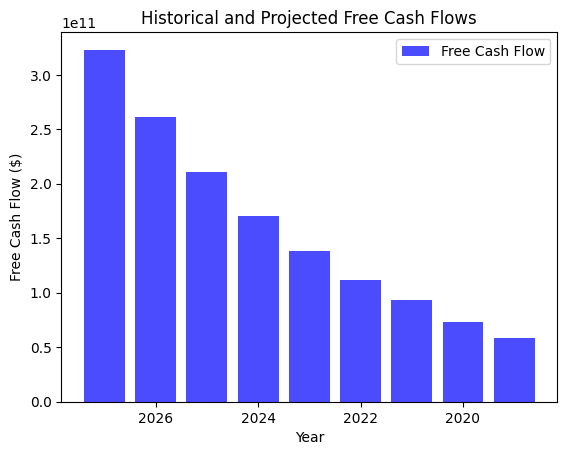

Current stock price for AAPL: $177.56
Intrinsic value per share for AAPL based on combined FCF: $193.83

Selected Stock Information:

                Attribute                 Value
0                longName            Apple Inc.
1                  sector            Technology
2                industry  Consumer Electronics
3               marketCap         2776008491008
4       sharesOutstanding           15634199552
5                    beta              1.274896
6        fiftyTwoWeekHigh                198.23
7         fiftyTwoWeekLow                124.17
8               forwardPE              26.86233
9              trailingPE             29.742044
10            sharesShort              88852352
11  sharesShortPriorMonth             126626604


In [16]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


def plot_free_cash_flows(historical_dates, projected_dates, historical_free_cash_flows, projected_free_cash_flows):
    combined_cash_flows = historical_free_cash_flows + projected_free_cash_flows
    combined_dates = [pd.to_datetime(date).year for date in (historical_dates + projected_dates)]

    plt.bar(combined_dates, combined_cash_flows, color='blue', alpha=0.7, label="Free Cash Flow")
    plt.xlabel('Year')
    plt.ylabel('Free Cash Flow ($)')
    plt.title('Historical and Projected Free Cash Flows')
    plt.legend()
    plt.gca().invert_xaxis()  # so that the most recent year appears on the left
    plt.show()

def get_current_stock_price(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    return ticker.info.get('currentPrice', None)


def get_free_cash_flow(ticker_symbol, years_back=10):
    ticker = yf.Ticker(ticker_symbol)
    cash_flow = ticker.cashflow.T
    if 'Free Cash Flow' in cash_flow.columns:
        flows = list(cash_flow['Free Cash Flow'].head(years_back))
        dates = list(cash_flow.index[:years_back])
        return flows, dates
    else:
        raise ValueError("No Free Cash Flow data available for this stock.")



def get_intrinsic_value(dcf_value, ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    shares_outstanding = ticker.info['sharesOutstanding']
    return dcf_value / shares_outstanding

def calculate_dcf(free_cash_flows, discount_rate):
    discounted_cash_flows = [cf / ((1 + discount_rate) ** (i+1)) for i, cf in enumerate(free_cash_flows)]
    return np.sum(discounted_cash_flows)

def get_wacc(ticker_symbol, risk_free_rate, market_return, tax_rate=0.21):
    ticker = yf.Ticker(ticker_symbol)
    E = ticker.info['marketCap']  # Market value of equity

    try:
        D = ticker.balance_sheet.T['Total Liabilities Net Minority Interest'][0]
    except KeyError:
        print("Available columns in the balance sheet:", ticker.balance_sheet.T.columns)
        raise ValueError(f"Cannot find 'Total Liabilities Net Minority Interest' in the balance sheet data for {ticker_symbol}.")

    V = E + D
    beta = ticker.info['beta']
    Re = risk_free_rate + beta * (market_return - risk_free_rate)  # CAPM

    # Improving Rd estimation
    try:
        debt = ticker.balance_sheet.T['Long Term Debt'][0]
        Rd = ticker.financials.T['Interest Expense'][0] / debt if debt != 0 else 0
    except:
        Rd = 0

    if Rd > 1:
        Rd = 0.05  # Using a 5% cost of debt as a fallback

    WACC = (E/V) * Re + (D/V) * Rd * (1 - tax_rate)
    return WACC

def calculate_terminal_value(last_fcf, growth_rate, discount_rate):
    if discount_rate == growth_rate:
        return float('inf')  # or handle in some other manner
    return last_fcf * (1 + growth_rate) / (discount_rate - growth_rate)

def sensitivity_analysis(ticker_symbol, risk_free_rate, market_return):
    wacc = get_wacc(ticker_symbol, risk_free_rate, market_return)
    base_dcf_value = calculate_dcf(get_free_cash_flow(ticker_symbol), wacc)

    discount_rates = np.linspace(wacc-0.03, wacc+0.03, 7)  # Varying WACC by 3% above and below
    growth_rates = np.linspace(-0.02, 0.04, 7)  # A range of growth rates from -2% to 4%

    results = []

    for dr in discount_rates:
        for gr in growth_rates:
            terminal_value = calculate_terminal_value(get_free_cash_flow(ticker_symbol)[0][-1], gr, dr)
            dcf_with_terminal = base_dcf_value + terminal_value / ((1 + dr) ** len(get_free_cash_flow(ticker_symbol)))
            intrinsic_value = get_intrinsic_value(dcf_with_terminal, ticker_symbol)
            results.append((dr, gr, intrinsic_value))

    return results

def project_future_fcf_and_terminal_value(free_cash_flows, years_to_project=5, perpetual_growth_rate=0.07, discount_rate=0.15):
    growth_rates = [free_cash_flows[i] / free_cash_flows[i+1] - 1 for i in range(len(free_cash_flows)-1)]
    average_growth_rate = np.mean(growth_rates)

    future_fcfs = [free_cash_flows[0]]
    for i in range(years_to_project):
        next_fcf = future_fcfs[-1] * (1 + average_growth_rate)
        future_fcfs.append(next_fcf)

    terminal_value = future_fcfs[-1] * (1 + perpetual_growth_rate) / (discount_rate - perpetual_growth_rate)

    return future_fcfs[1:], terminal_value


def plot_sensitivity_analysis(results):
    discount_rates = sorted(list(set([x[0] for x in results])))
    growth_rates = sorted(list(set([x[1] for x in results])))

    values = np.array([x[2] for x in results]).reshape(len(discount_rates), len(growth_rates))

    plt.figure(figsize=(10, 6))
    cp = plt.contourf(growth_rates, discount_rates, values, 50, cmap="viridis")
    plt.colorbar(cp, label="Intrinsic Value ($)")
    plt.xlabel('Growth Rate')
    plt.ylabel('Discount Rate (WACC)')
    plt.title('Sensitivity Analysis of Intrinsic Value')
    plt.show()

def get_ticker_info(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    info_keys = ['longName', 'sector', 'industry', 'marketCap', 'sharesOutstanding',
                 'beta', 'fiftyTwoWeekHigh', 'fiftyTwoWeekLow', 'forwardPE', 'trailingPE','sharesShort','sharesShortPriorMonth']
    info_data = {key: ticker.info.get(key, "N/A") for key in info_keys}
    return info_data

def display_info_table(ticker_symbol):
    ticker_info = get_ticker_info(ticker_symbol)
    df = pd.DataFrame(list(ticker_info.items()), columns=['Attribute', 'Value'])
    print(df)


if __name__ == "__main__":
    ticker_symbol = "AAPL"
    risk_free_rate = 0.05
    market_return = 0.08

    try:
        discount_rate = get_wacc(ticker_symbol, risk_free_rate, market_return)
        print(f"Calculated WACC for {ticker_symbol} is {discount_rate*100:.2f}%")

        historical_free_cash_flows, historical_dates = get_free_cash_flow(ticker_symbol)

        # Projected FCF
        projected_free_cash_flows, terminal_value = project_future_fcf_and_terminal_value(historical_free_cash_flows[-5:])

        # Extend dates for projected cash flows
        last_date = pd.to_datetime(historical_dates[0])
        projected_dates = [(last_date + pd.DateOffset(years=i+1)).strftime('%Y-%m-%d') for i in range(len(projected_free_cash_flows))]

        plot_free_cash_flows(historical_dates, projected_dates, historical_free_cash_flows, projected_free_cash_flows)

        combined_free_cash_flows = historical_free_cash_flows + projected_free_cash_flows

        dcf_value = calculate_dcf(combined_free_cash_flows, discount_rate)
        dcf_value += terminal_value / ((1 + discount_rate) ** (len(combined_free_cash_flows)))

        intrinsic_value = get_intrinsic_value(dcf_value, ticker_symbol)

        current_price = get_current_stock_price(ticker_symbol)

        if current_price:
            print(f"Current stock price for {ticker_symbol}: ${current_price:.2f}")
        else:
            print(f"Couldn't fetch the current stock price for {ticker_symbol}.")

        print(f"Intrinsic value per share for {ticker_symbol} based on combined FCF: ${intrinsic_value:.2f}")

        # sensitivity_results = sensitivity_analysis(ticker_symbol, risk_free_rate, market_return)
        # plot_sensitivity_analysis(sensitivity_results)
        print("\nSelected Stock Information:\n")
        display_info_table(ticker_symbol)

    except Exception as e:
        print(str(e))